In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.contrib import rnn

In [2]:
readfile = '~/python/tensorflow/JolleFishData/170202_pi11_SOLI_S17_F175_TR.csv'
model_path = 'ModelCheckpoints/four_border_distance_pred_delta_xy-64-all.ckpt'

# Training parameters
learning_rate = 0.001
dropout = 0.2
n_epochs = 100
batch_size = 512
display_step = 10

# Network parameters
n_input = 4            # number of dimensions in input
n_output = 2           # number of dimensions in output
n_embedded = 256
n_per_hidden = 64     # number of nodes per hidden layer
    # Note: we require that all hidden layers have the same number of nodes
n_hidden_layers = 2    # number of hidden layers
window_length = 50    # length of lookback window to give the LSTM

In [3]:
def download_data(filename):
    """download the csv file stored at 'filename'.
    Drop unnecessary columns."""
    data = pd.read_csv(readfile, sep=",", header=0, index_col=4)  # 'frame' is the 5th column in the csv
    data = data.drop(['date', 'test', 'session', 'tank'], axis=1)
        # these columns are constant over the whole file
        # remaining columns: 'x', 'y', 'borderdistance', 'displacement', 'distmoved', 'speed', 'orientation', 'heading'
    return data
    
def add_wall_distances(data):
    """Add columns to dataframe 'data' that indicate fish's
    distance from each of the four walls.
    Includes sanity check to be verified by the user,
    to ensure that inferred extremum values seem reasonable."""
    min_possible_x = (data['x'] - data['borderdistance']).min()
    min_observed_x = data['x'].min()
    max_possible_x = (data['x'] + data['borderdistance']).max()
    max_observed_x = data['x'].max()
    min_possible_y = (data['y'] - data['borderdistance']).min()
    min_observed_y = data['y'].min()
    max_possible_y = (data['y'] + data['borderdistance']).max()
    max_observed_y = data['y'].max()

    # TODO: pretty-ify this to make it more user-friendly
    print('Sanity check: do these values look reasonable to you?')
    print('Inferred min x: ' + str(min_possible_x) + '; observed min x: ' + str(min_observed_x))
    print('Inferred max x: ' + str(max_possible_x) + '; observed max x: ' + str(max_observed_x))
    print('Inferred min y: ' + str(min_possible_y) + '; observed min y: ' + str(min_observed_y))
    print('Inferred max y: ' + str(max_possible_y) + '; observed max y: ' + str(max_observed_y))
    
    data['xmin_borderdistance'] = data['x'] - min_possible_x
    data['xmax_borderdistance'] = max_possible_x - data['x']
    data['ymin_borderdistance'] = data['y'] - min_possible_y
    data['ymax_borderdistance'] = max_possible_y - data['y']
    
    return data

def add_delta_position(data):
    data['delta_x'] = data['x'].diff()
    data['delta_y'] = data['y'].diff()
    
    data = data.dropna()
    
    return data

In [4]:
def normalize_windows(windows):
    """normalize the data in a given window, so that all points except possibly the last lie in [0,1]"""
    normalized_windows = []
    for window in windows:
        mins = window[:-1,:].min(axis=0)   # leave out the last row when normalizing
        maxes = window[:-1,:].max(axis=0)  # leave out the last row when normalizing
        normalized_window = (window-mins)/(maxes-mins)
        normalized_windows.append(normalized_window)
    return normalized_windows

def partition_windows(windows, window_length, train_percent, valid_percent, test_percent):
    n_windows = len(windows)
    possible_overlap = 2*window_length
    n_windows -= possible_overlap
    
    n_train = n_windows*train_percent//100
    n_valid = n_windows*valid_percent//100
    n_test  = n_windows*test_percent//100

    train = windows[:n_train,:,:]
    valid = windows[n_train+window_length:n_train+n_valid+window_length,:,:]
    test  = windows[n_train+n_valid+2*window_length:,:,:]
    
    return train, valid, test
    
# TODO: find way to preserve column headers within windows
def preprocess_data(data, window_length=window_length, normalize=False):
    """break into windows, each of length 'window_length'"""

    windows = []
    for index in range(len(data) - window_length):
        windows.append(np.array(data.iloc[index:index+window_length,:]))
    
    if normalize:
        windows = normalize_windows(windows)
    
    windows = np.array(windows)
    
    # 80% training, 10% test, 10% validation
    train, valid, test = partition_windows(windows, window_length, 80, 10, 10)

    # randomize the order
    np.random.shuffle(train)
    np.random.shuffle(valid)
    np.random.shuffle(test)
    
    # select data of interest:
        # 'xmin_borderdistance', 'xmax_borderdistance', 'ymin_borderdistance', 'ymax_borderdistance'
        # for input, and
        # 'x', 'y' for output
    # x is everything except last row, y is the last row
    x_train = train[:, :-1, 8:12]
    y_train = train[:,  -1,12:]
    x_valid = valid[:, :-1, 8:12]
    y_valid = valid[: , -1,12:]
    x_test  =  test[: ,:-1, 8:12]
    y_test  =  test[: , -1,12:]

    return x_train, y_train, x_valid, y_valid, x_test, y_test

In [5]:
def plot_fit(true_data, predicted_data):
    slope = 1
    intercept = 0

    n_points = len(true_data)
    for series_index in range(true_data.shape[1]):
        x_data = true_data[:,series_index].reshape(n_points)
        y_data = predicted_data[:,series_index].reshape(n_points)
        abline = [slope * x + intercept for x in x_data]  # line of slope 1 and y-intercept 0

        print("\nDisplaying graph for dataseries " + str(series_index) + ":")
        plt.scatter(x_data, y_data, color='black')
        plt.plot(np.unique(x_data), np.poly1d(
            np.polyfit(x_data, y_data, 1))(np.unique(x_data)), color='red')  # line of best fit
        plt.plot(x_data, abline, color='blue')  

        plt.xlabel('Actual value')
        plt.ylabel('Predicted value')
        plt.show()

In [6]:
# Return a random window
def get_next_window(x_data, y_data):
    index = np.random.randint(0, len(x_data))
    inputs = x_data[index,:,:]
    output = y_data[index,:] 
    return inputs, output
    
# Generate a batch of batch_size random windows
def get_new_batch(x_data, y_data, batch_size):
    inputs = np.empty((batch_size, window_length-1, n_input))
    outputs = np.empty((batch_size, n_output))
    for index in range(batch_size):
        inputs[index,:,:], outputs[index,:] = get_next_window(x_data, y_data)
    return inputs, outputs

In [7]:
l2_parameter = 0.001

graph = tf.Graph()

with graph.as_default():

    # Input data
    x_batch_placeholder = tf.placeholder(tf.float32,
                                      shape=(None, window_length-1, n_input))
        # None so that able to hold differently sized batches
    y_batch_placeholder = tf.placeholder(tf.float32, shape=(None, n_output))
        # None so that able to hold differently sized batches
    dropout_placeholder = tf.placeholder(tf.float32)

    # Variables to be trained
    weights = tf.Variable(tf.truncated_normal([n_per_hidden, n_output]))
    biases = tf.Variable(tf.zeros([n_output]))
    weights2 = tf.Variable(tf.truncated_normal([n_input, n_embedded]))
    
    # Build graph
    cells = []
    for _ in range(n_hidden_layers):
        cell = rnn.BasicLSTMCell(n_per_hidden)
        cell = rnn.DropoutWrapper(cell, output_keep_prob=1.0 - dropout_placeholder)
        cells.append(cell)
    cell = rnn.MultiRNNCell(cells)
    
    
    # Define ops to run forward pass
    stacks = []
    for i in range(window_length-1):
        stacks.append(tf.nn.relu(tf.matmul(x_batch_placeholder[:,i,:], weights2)))
    embedd = tf.stack(stacks, axis=1)
    print(embedd.shape)
    outputs, states = tf.nn.dynamic_rnn(cell, embedd, dtype=tf.float32)
    logits = tf.matmul(outputs[:,-1,:], weights) + biases
    
    # Define cost and optimizer
    cost = tf.sqrt(tf.reduce_mean(tf.squared_difference(logits, y_batch_placeholder)))+l2_parameter*(tf.nn.l2_loss(weights)+tf.nn.l2_loss(biases)+tf.nn.l2_loss(weights2))  # cost function is rms
    optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)
    
    # Define op to initialize global variables
    init = tf.global_variables_initializer()
    
    # Define Saver op class to save and restore model
    saver = tf.train.Saver()

(?, 49, 128)


In [8]:
def train_model(
    n_epochs=n_epochs,
    display_step=display_step,
    learning_rate=learning_rate,
    batch_size=batch_size,
    graph=graph,
    restore_from_save=True,
    restore_path=model_path,
    save_when_finished=True,
    save_path=model_path):
    
    # Launch the graph
    with tf.Session(graph=graph) as sess:
        if restore_from_save:
            try:
                saver.restore(sess, restore_path)
                print("Model successfully restored from %s.\nResuming training." % restore_path)
            except tf.errors.NotFoundError:
                print("Save file not found.\nInitializing graph from scratch instead.")
                sess.run(init)
                print("Global variables initialized.\nCommencing training.")
        else:
            sess.run(init)
            print("Global variables initialized.\nCommencing training.")

        # Keep training until reach max iterations
        for epoch_idx in range(n_epochs):
            _x_batch, _y_batch = get_new_batch(x_train, y_train, batch_size)

            # Run optimization op (backprop)
            feed_dict = {x_batch_placeholder: _x_batch, y_batch_placeholder: _y_batch, dropout_placeholder: dropout}
            _train_cost, _ = sess.run([cost, optimizer], feed_dict=feed_dict)

            if epoch_idx % display_step == 0:
                _valid_cost = sess.run(
                    cost, feed_dict={x_batch_placeholder: x_valid, y_batch_placeholder: y_valid, dropout_placeholder: dropout})
                print("Epoch " + str(epoch_idx) + ", Minibatch cost = " + \
                      "{:.6f}".format(_train_cost))
                print("Epoch " + str(epoch_idx) + ", Validation set cost = " + \
                      "{:.6f}".format(_valid_cost))

        if save_when_finished:
            # Save model weights to disk
            _save_path = saver.save(sess, save_path)
            print("Model saved in file: %s" % _save_path)

        # Plot fit on validation data
        print("\nCurrent validation performance:")
        plot_fit(y_valid, logits.eval(feed_dict={x_batch_placeholder: x_valid, dropout_placeholder: 0}))

In [9]:
def extract_wall_distances(prediction, seed):
    new_wall_distances = np.zeros(4)
    new_wall_distances[0] = seed[-1,0]+prediction[0,0]  # new distance from min x
    new_wall_distances[1] = seed[-1,1]-prediction[0,0]  # new distance from max x
    new_wall_distances[2] = seed[-1,2]+prediction[0,1]  # new distance from min y
    new_wall_distances[3] = seed[-1,3]-prediction[0,1]  # new distance from max y
    
    new_coords = np.array([new_wall_distances[0], new_wall_distances[2]])
    
    return new_wall_distances, new_coords
    
def generate_next_point(seed, sess):
    random_scalar = 1/4
    feed_dict = {x_batch_placeholder: seed, dropout_placeholder: 0}
    _logits = logits.eval(session=sess, feed_dict=feed_dict)
    _logits = _logits + np.random.randn(1,2)*random_scalar
    # print (_logits.shape,type(_logits))
    return _logits
    
def shift_seed(old_seed, new_row):
    return np.vstack([old_seed[1:,:], new_row])
    
def generate_prediction(seed, prediction_length, restore_path=model_path, progress_counter=20):
    """Starting from an unnormalized seed sequence and generate a new sequence of positions"
    Params:
        seed: ndarray, shape (1, window_length-1, n_input)
        prediction_length: integer, number of desired timesteps to generate
        restore_path: string, location from which to load saved graph state
        progress_counter: integer, indicates number of intervals to print progress in generating sequence
    Returns:
        array of predicted locations, of shape shape (prediction_length, n_output)
    """
    with tf.Session(graph=graph) as sess:
        # load the variables
        try:
            saver.restore(sess, restore_path)
            print("Model successfully restored from %s.\nGenerating sequence." % restore_path)
        except tf.errors.NotFoundError:  # TODO: add type of error
            print("Save file not found.\nExiting.")
            return
        
        predictions = []
        show_interval = prediction_length//progress_counter
        
        for index in range(prediction_length):
            if index % show_interval == 0:
                print("Generated", index, "of", prediction_length, "data points.")
            batch_seed = seed.reshape(1, window_length-1, n_input)  # cast to batch format (batch of size 1)
            prediction = generate_next_point(batch_seed, sess)
            wall_distances, pred_coords = extract_wall_distances(prediction, seed)
            predictions.append(pred_coords)
            seed = shift_seed(seed, wall_distances)
        print("Done!")
        
        return np.array(predictions)

In [10]:
# Load data, add required columns
all_data = download_data(readfile)
all_data = add_wall_distances(all_data)
all_data = add_delta_position(all_data)

Sanity check: do these values look reasonable to you?
Inferred min x: 0.0; observed min x: 10.2
Inferred max x: 775.0; observed max x: 772.4
Inferred min y: 0.0; observed min y: 3.9
Inferred max y: 515.3; observed max y: 507.4


In [11]:
# Create training, validation, and test sets
x_train, y_train, x_valid, y_valid, x_test, y_test = preprocess_data(
    all_data, window_length=window_length, normalize=False)

Global variables initialized.
Commencing training.
Epoch 0, Minibatch cost = 3.866500
Epoch 0, Validation set cost = 3.745833
Epoch 10, Minibatch cost = 3.288702
Epoch 10, Validation set cost = 3.266451
Epoch 20, Minibatch cost = 3.055071
Epoch 20, Validation set cost = 2.995085
Epoch 30, Minibatch cost = 2.990436
Epoch 30, Validation set cost = 2.862905
Epoch 40, Minibatch cost = 2.957996
Epoch 40, Validation set cost = 2.921077
Epoch 50, Minibatch cost = 2.958490
Epoch 50, Validation set cost = 2.767908
Epoch 60, Minibatch cost = 3.103451
Epoch 60, Validation set cost = 2.886587
Epoch 70, Minibatch cost = 3.127445
Epoch 70, Validation set cost = 2.843311
Epoch 80, Minibatch cost = 2.682194
Epoch 80, Validation set cost = 2.798267
Epoch 90, Minibatch cost = 3.018350
Epoch 90, Validation set cost = 2.546698
Epoch 100, Minibatch cost = 2.906936
Epoch 100, Validation set cost = 2.543051
Epoch 110, Minibatch cost = 2.766016
Epoch 110, Validation set cost = 2.684008
Epoch 120, Minibatch co

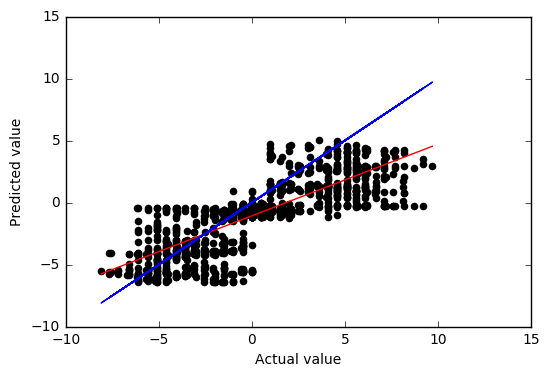


Displaying graph for dataseries 1:


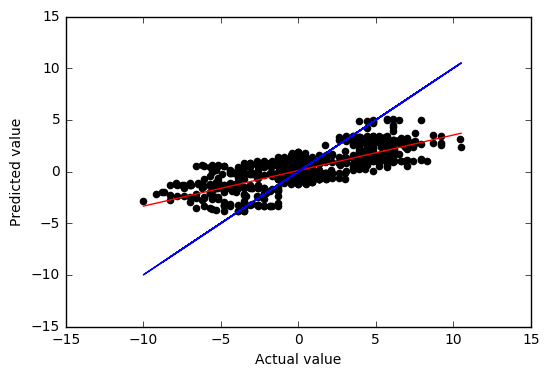

In [12]:
train_model(n_epochs=200,display_step=10,learning_rate=0.01, restore_from_save=False)

INFO:tensorflow:Restoring parameters from ModelCheckpoints/four_border_distance_pred_delta_xy-64-all.ckpt
Model successfully restored from ModelCheckpoints/four_border_distance_pred_delta_xy-64-all.ckpt.
Resuming training.
Epoch 0, Minibatch cost = 2.601375
Epoch 0, Validation set cost = 2.455835
Epoch 10, Minibatch cost = 2.709709
Epoch 10, Validation set cost = 2.439287
Epoch 20, Minibatch cost = 2.504581
Epoch 20, Validation set cost = 2.203052
Epoch 30, Minibatch cost = 2.344578
Epoch 30, Validation set cost = 2.355909
Epoch 40, Minibatch cost = 2.387167
Epoch 40, Validation set cost = 2.186301
Epoch 50, Minibatch cost = 2.387004
Epoch 50, Validation set cost = 2.154756
Epoch 60, Minibatch cost = 2.250487
Epoch 60, Validation set cost = 2.465473
Epoch 70, Minibatch cost = 2.395665
Epoch 70, Validation set cost = 2.363204
Epoch 80, Minibatch cost = 2.212458
Epoch 80, Validation set cost = 2.190989
Epoch 90, Minibatch cost = 2.288987
Epoch 90, Validation set cost = 2.438413
Epoch 100

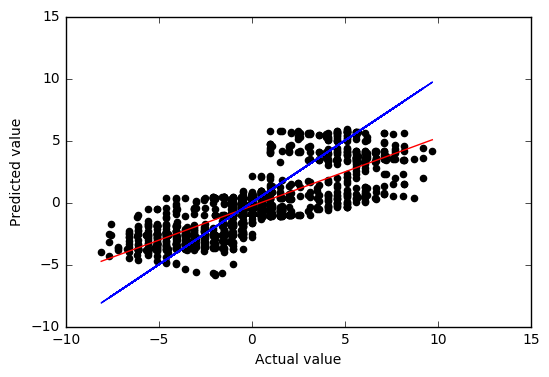


Displaying graph for dataseries 1:


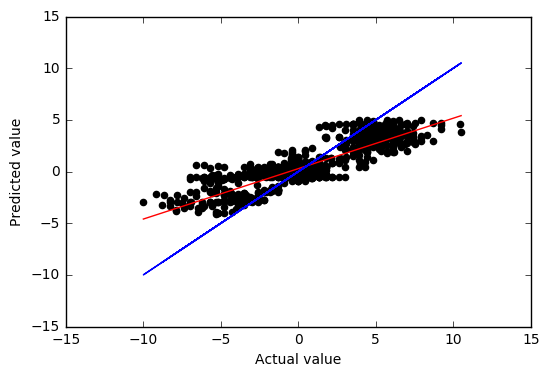

In [13]:
train_model(n_epochs=200,display_step=10,learning_rate=0.001, restore_from_save=True)

INFO:tensorflow:Restoring parameters from ModelCheckpoints/four_border_distance_pred_delta_xy-64-all.ckpt
Model successfully restored from ModelCheckpoints/four_border_distance_pred_delta_xy-64-all.ckpt.
Resuming training.
Epoch 0, Minibatch cost = 2.202836
Epoch 0, Validation set cost = 1.976240
Epoch 10, Minibatch cost = 2.089878
Epoch 10, Validation set cost = 2.137697
Epoch 20, Minibatch cost = 2.272909
Epoch 20, Validation set cost = 2.144933
Epoch 30, Minibatch cost = 2.180379
Epoch 30, Validation set cost = 2.076130
Epoch 40, Minibatch cost = 2.077430
Epoch 40, Validation set cost = 2.134602
Epoch 50, Minibatch cost = 2.057528
Epoch 50, Validation set cost = 2.138757
Epoch 60, Minibatch cost = 2.059489
Epoch 60, Validation set cost = 2.297363
Epoch 70, Minibatch cost = 2.142275
Epoch 70, Validation set cost = 1.991557
Epoch 80, Minibatch cost = 2.049277
Epoch 80, Validation set cost = 2.059683
Epoch 90, Minibatch cost = 2.006504
Epoch 90, Validation set cost = 1.919260
Epoch 100

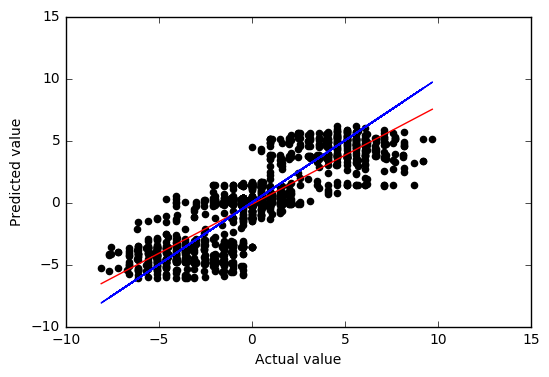


Displaying graph for dataseries 1:


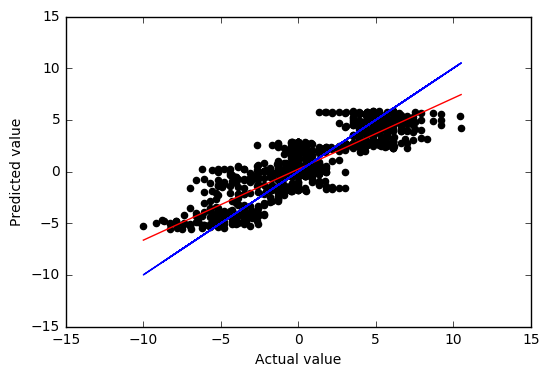

In [14]:
train_model(n_epochs=300,display_step=10,learning_rate=0.0001, restore_from_save=True)

In [15]:
filename = 'predict_window_50-2.csv'
seed = x_train[101]
predictions = generate_prediction(seed, 5000, restore_path=model_path, progress_counter=20)
np.savetxt(filename, predictions, delimiter=",")

INFO:tensorflow:Restoring parameters from ModelCheckpoints/four_border_distance_pred_delta_xy-64-all.ckpt
Model successfully restored from ModelCheckpoints/four_border_distance_pred_delta_xy-64-all.ckpt.
Generating sequence.
Generated 0 of 5000 data points.
Generated 250 of 5000 data points.
Generated 500 of 5000 data points.
Generated 750 of 5000 data points.
Generated 1000 of 5000 data points.
Generated 1250 of 5000 data points.
Generated 1500 of 5000 data points.
Generated 1750 of 5000 data points.
Generated 2000 of 5000 data points.
Generated 2250 of 5000 data points.
Generated 2500 of 5000 data points.
Generated 2750 of 5000 data points.
Generated 3000 of 5000 data points.
Generated 3250 of 5000 data points.
Generated 3500 of 5000 data points.
Generated 3750 of 5000 data points.
Generated 4000 of 5000 data points.
Generated 4250 of 5000 data points.
Generated 4500 of 5000 data points.
Generated 4750 of 5000 data points.
Done!


In [16]:
# TODO: DELETE THIS SANDBOX
# NOTE: THIS IS THE SOLUTION
mini_data = all_data.iloc[:100,:]
mycolumn_types = [str(mini_data[x].dtype) for x in mini_data]
mydtypes = list(zip(mini_data.columns.values,mycolumn_types))
print(np.array(mini_data,dtype=mydtypes)['x'][:,0])
print('---------------')
print(np.array(mini_data,dtype=mydtypes))
print('---------------')
print(np.array(mini_data))
print('---------------')
np.array(mini_data,dtype=mydtypes)

[ 391.8  393.9  394.4  397.4  401.   403.6  405.6  408.7  412.8  415.8
  417.9  421.4  426.5  430.6  434.2  436.7  439.3  442.3  446.9  450.5
  454.1  459.7  467.3  473.5  479.6  484.7  489.3  493.9  500.5  507.7
  514.3  519.9  527.   534.2  541.3  546.9  552.6  556.6  560.7  564.8
  568.4  571.9  574.5  577.   579.6  582.1  583.7  586.2  590.3  594.4
  600.   607.1  613.3  618.9  623.5  628.1  632.1  636.2  641.3  646.9
  652.   657.1  660.7  663.8  666.3  667.9  669.4  669.9  670.4  671.4
  671.9  672.4  673.5  673.5  674.   674.5  674.5  675.   675.5  676.5
  676.5  676.5  676.5  676.5  677.   678.1  677.6  681.6  686.7  690.8
  694.4  699.5  703.6  707.7  711.2  714.8  718.9  723.   726.   728.6]
---------------
[[ (  3.91800000e+02,   3.91800000e+02,   3.91800000e+02,   3.91800000e+02,   3.91800000e+02,   3.91800000e+02,   3.91800000e+02,   3.91800000e+02,   3.91800000e+02,   3.91800000e+02,   3.91800000e+02,   3.91800000e+02,   3.91800000e+02,   3.91800000e+02)
  (  2.14400000e+

array([[ (  3.91800000e+02,   3.91800000e+02,   3.91800000e+02,   3.91800000e+02,   3.91800000e+02,   3.91800000e+02,   3.91800000e+02,   3.91800000e+02,   3.91800000e+02,   3.91800000e+02,   3.91800000e+02,   3.91800000e+02,   3.91800000e+02,   3.91800000e+02),
        (  2.14400000e+02,   2.14400000e+02,   2.14400000e+02,   2.14400000e+02,   2.14400000e+02,   2.14400000e+02,   2.14400000e+02,   2.14400000e+02,   2.14400000e+02,   2.14400000e+02,   2.14400000e+02,   2.14400000e+02,   2.14400000e+02,   2.14400000e+02),
        (  2.14400000e+02,   2.14400000e+02,   2.14400000e+02,   2.14400000e+02,   2.14400000e+02,   2.14400000e+02,   2.14400000e+02,   2.14400000e+02,   2.14400000e+02,   2.14400000e+02,   2.14400000e+02,   2.14400000e+02,   2.14400000e+02,   2.14400000e+02),
        ...,
        (  3.00900000e+02,   3.00900000e+02,   3.00900000e+02,   3.00900000e+02,   3.00900000e+02,   3.00900000e+02,   3.00900000e+02,   3.00900000e+02,   3.00900000e+02,   3.00900000e+02,   3.0090000

In [17]:
mini_data = all_data.iloc[:100,:]
mycolumn_types = [str(mini_data[x].dtype) for x in mini_data]
mydtypes = list(zip(mini_data.columns.values,mycolumn_types))
#print(np.array(mini_data.values,dtype=mydtypes, copy=False))
print(mydtypes)
type(mini_data.values)

[('x', 'float64'), ('y', 'float64'), ('borderdistance', 'float64'), ('displacement', 'float64'), ('distmoved', 'float64'), ('speed', 'float64'), ('orientation', 'float64'), ('heading', 'float64'), ('xmin_borderdistance', 'float64'), ('xmax_borderdistance', 'float64'), ('ymin_borderdistance', 'float64'), ('ymax_borderdistance', 'float64'), ('delta_x', 'float64'), ('delta_y', 'float64')]


numpy.ndarray

In [18]:
mycolumn_types = [str(mini_data[x].dtype) for x in mini_data]
mycolumn_names = list(mini_data.columns.values)
zipped = list(zip(mycolumn_names,mycolumn_types))
print(zipped)
np.dtype(zipped)
np.dtype([('f1', np.uint), ('f2', np.int32)])

[('x', 'float64'), ('y', 'float64'), ('borderdistance', 'float64'), ('displacement', 'float64'), ('distmoved', 'float64'), ('speed', 'float64'), ('orientation', 'float64'), ('heading', 'float64'), ('xmin_borderdistance', 'float64'), ('xmax_borderdistance', 'float64'), ('ymin_borderdistance', 'float64'), ('ymax_borderdistance', 'float64'), ('delta_x', 'float64'), ('delta_y', 'float64')]


dtype([('f1', '<u8'), ('f2', '<i4')])

In [19]:
len(all_data)

14798

INFO:tensorflow:Restoring parameters from ModelCheckpoints/four_border_distance_pred_delta_xy-64-all.ckpt
Model successfully restored from ModelCheckpoints/four_border_distance_pred_delta_xy-64-all.ckpt.
Resuming training.
Epoch 0, Minibatch cost = 1.988807
Epoch 0, Validation set cost = 1.911442
Epoch 1, Minibatch cost = 2.004714
Epoch 1, Validation set cost = 1.902990
Epoch 2, Minibatch cost = 2.036851
Epoch 2, Validation set cost = 1.917483
Epoch 3, Minibatch cost = 2.001783
Epoch 3, Validation set cost = 1.906150
Epoch 4, Minibatch cost = 2.032369
Epoch 4, Validation set cost = 2.094513
Epoch 5, Minibatch cost = 2.039375
Epoch 5, Validation set cost = 2.003949
Epoch 6, Minibatch cost = 2.120942
Epoch 6, Validation set cost = 1.938075
Epoch 7, Minibatch cost = 2.065481
Epoch 7, Validation set cost = 1.983036
Epoch 8, Minibatch cost = 1.973800
Epoch 8, Validation set cost = 1.935004
Epoch 9, Minibatch cost = 1.987033
Epoch 9, Validation set cost = 1.952705
Epoch 10, Minibatch cost = 

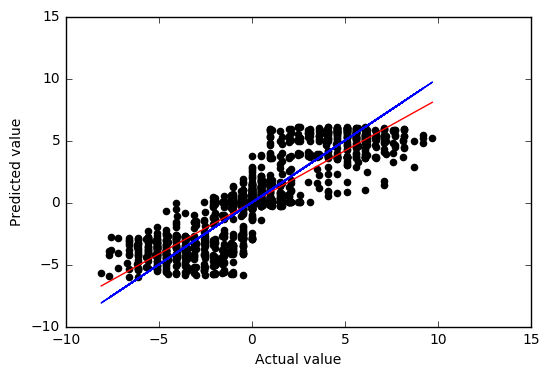


Displaying graph for dataseries 1:


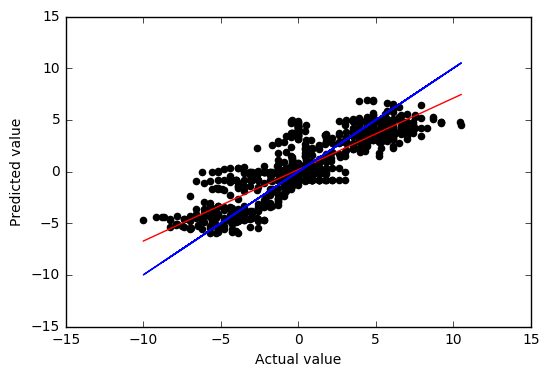

In [20]:
train_model(n_epochs=500,display_step=10,learning_rate=0.00001, restore_from_save=True)

In [21]:
 filename = 'predict_window_50-2.csv'
seed = x_train[101]
predictions = generate_prediction(seed, 5000, restore_path=model_path, progress_counter=20)
np.savetxt(filename, predictions, delimiter=",")

INFO:tensorflow:Restoring parameters from ModelCheckpoints/four_border_distance_pred_delta_xy-64-all.ckpt
Model successfully restored from ModelCheckpoints/four_border_distance_pred_delta_xy-64-all.ckpt.
Generating sequence.
Generated 0 of 5000 data points.
Generated 250 of 5000 data points.
Generated 500 of 5000 data points.
Generated 750 of 5000 data points.
Generated 1000 of 5000 data points.
Generated 1250 of 5000 data points.
Generated 1500 of 5000 data points.
Generated 1750 of 5000 data points.
Generated 2000 of 5000 data points.
Generated 2250 of 5000 data points.
Generated 2500 of 5000 data points.
Generated 2750 of 5000 data points.
Generated 3000 of 5000 data points.
Generated 3250 of 5000 data points.
Generated 3500 of 5000 data points.
Generated 3750 of 5000 data points.
Generated 4000 of 5000 data points.
Generated 4250 of 5000 data points.
Generated 4500 of 5000 data points.
Generated 4750 of 5000 data points.
Done!


INFO:tensorflow:Restoring parameters from ModelCheckpoints/four_border_distance_pred_delta_xy-64-all.ckpt
Model successfully restored from ModelCheckpoints/four_border_distance_pred_delta_xy-64-all.ckpt.
Resuming training.
Epoch 0, Minibatch cost = 1.891643
Epoch 0, Validation set cost = 1.745668
Epoch 1, Minibatch cost = 1.849551
Epoch 1, Validation set cost = 1.764434
Epoch 2, Minibatch cost = 1.766685
Epoch 2, Validation set cost = 1.755637
Epoch 3, Minibatch cost = 1.800393
Epoch 3, Validation set cost = 1.776155
Epoch 4, Minibatch cost = 1.849827
Epoch 4, Validation set cost = 1.821070
Epoch 5, Minibatch cost = 1.831081
Epoch 5, Validation set cost = 1.825677
Epoch 6, Minibatch cost = 1.889863
Epoch 6, Validation set cost = 2.022732
Epoch 7, Minibatch cost = 1.768138
Epoch 7, Validation set cost = 1.966591
Epoch 8, Minibatch cost = 1.963391
Epoch 8, Validation set cost = 1.808799
Epoch 9, Minibatch cost = 1.828434
Epoch 9, Validation set cost = 1.791394
Epoch 10, Minibatch cost = 

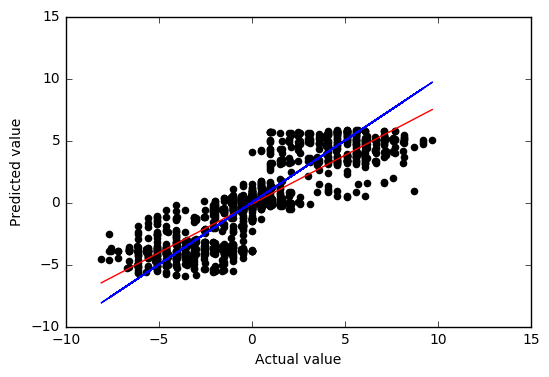


Displaying graph for dataseries 1:


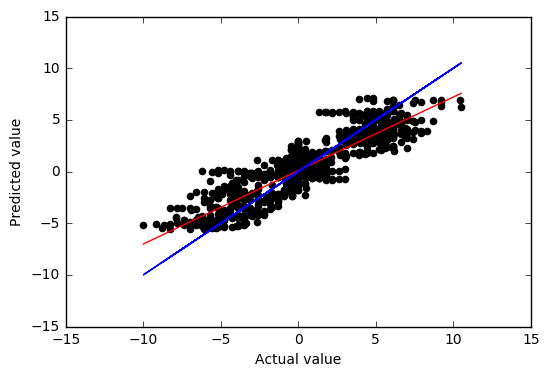

In [22]:
train_model(n_epochs=500,display_step=10,learning_rate=0.0001, restore_from_save=True)

In [23]:
 filename = 'predict_window_50-2.csv'
seed = x_train[101]
predictions = generate_prediction(seed, 5000, restore_path=model_path, progress_counter=20)
np.savetxt(filename, predictions, delimiter=",")

INFO:tensorflow:Restoring parameters from ModelCheckpoints/four_border_distance_pred_delta_xy-64-all.ckpt
Model successfully restored from ModelCheckpoints/four_border_distance_pred_delta_xy-64-all.ckpt.
Generating sequence.
Generated 0 of 5000 data points.
Generated 250 of 5000 data points.
Generated 500 of 5000 data points.
Generated 750 of 5000 data points.
Generated 1000 of 5000 data points.
Generated 1250 of 5000 data points.
Generated 1500 of 5000 data points.
Generated 1750 of 5000 data points.
Generated 2000 of 5000 data points.
Generated 2250 of 5000 data points.
Generated 2500 of 5000 data points.
Generated 2750 of 5000 data points.
Generated 3000 of 5000 data points.
Generated 3250 of 5000 data points.
Generated 3500 of 5000 data points.
Generated 3750 of 5000 data points.
Generated 4000 of 5000 data points.
Generated 4250 of 5000 data points.
Generated 4500 of 5000 data points.
Generated 4750 of 5000 data points.
Done!
